# Exploring Dandiset 001349: Two-Photon Calcium Imaging in Developing Mouse Somatosensory Cortex

*Generated with the assistance of AI. Please review code and results with care before drawing scientific conclusions.*

## Introduction

This notebook is designed to help researchers get started exploring [Dandiset 001349 (version 0.250520.1729)](https://dandiarchive.org/dandiset/001349/0.250520.1729).

**Title**: From Initial Formation to Developmental Refinement: GABAergic Inputs Shape Neuronal Subnetworks in the Primary Somatosensory Cortex  

**Overview**:  
This Dandiset contains two-photon calcium imaging data acquired from the primary somatosensory cortex of developing mice. The data is organized in the Neurodata Without Borders (NWB) format and captures activity across several developmental stages, with synchronized behavioral video (not included in this particular file). The main focus is on processed calcium imaging data for hundreds of segmented regions of interest (ROIs), alongside segmentation masks and imaging metadata.

## What this notebook covers

This notebook will guide you through:
- Querying Dandiset 001349 using the DANDI API.
- Identifying NWB files in the Dandiset.
- Streaming and opening an NWB file using pynwb and remfile.
- Listing available calcium imaging (ophys) datasets for a selected session.
- Visualizing ΔF/F time series and raw fluorescence from a single ROI.
- Viewing the spatial footprint (mask) of a selected ROI.

The focus is entirely on content documented in this session—no additional data or files are accessed.

## Required Packages

The following packages are required and assumed to be pre-installed:
- `dandi`
- `pynwb`
- `remfile`
- `h5py`
- `matplotlib`
- `numpy`
- `pandas`

If you encounter import errors, please ensure you have these packages available in your environment.

## 1. Query Dandiset Assets Using the DANDI API

We start by connecting to the DANDI archive and listing several of the NWB files present in Dandiset 001349, version 0.250520.1729.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

# Connect to the DANDI archive and get the specified dandiset
dandiset_id = "001349"
dandiset_version = "0.250520.1729"

client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List the first 10 NWB files in the Dandiset
assets = dandiset.get_assets_by_glob("*.nwb")
first_10_assets = list(islice(assets, 10))
print("First 10 NWB file paths in the dandiset:")
for asset in first_10_assets:
    print(asset.path)

First 10 NWB file paths in the dandiset:
sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb
sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-1_ophys.nwb
sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-2_ophys.nwb
sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-3_ophys.nwb
sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-0_ophys.nwb
sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-4_ophys.nwb
sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-1_ophys.nwb
sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-11_ophys.nwb
sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-12_ophys.nwb
sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-13_ophys.nwb


## 2. Select an NWB File for Inspection

We'll select the file `sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb` for all analyses below. 

> **Tip**: You can substitute any path from the Dandiset for your own reanalysis!

In [2]:
selected_nwb_path = "sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb"

# Get the asset object and streaming URL for this file
selected_asset = next(dandiset.get_assets_by_glob(selected_nwb_path))
print(f"Streaming NWB file: {selected_asset.path}")

Streaming NWB file: sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb


## 3. Stream and Open the NWB File

We'll use `remfile` to stream the data directly from DANDI, and open it using `h5py` and `pynwb.NWBHDF5IO`.
This avoids the need to fully download the file and enables efficient access even to large datasets.

In [3]:
import remfile
import h5py
import pynwb

# Get the streaming URL
nwb_url = selected_asset.download_url

# Stream using remfile, open with h5py and pynwb
remote_file = remfile.File(nwb_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

print(f"NWB session description: {nwb.session_description}")
print(f"Subject: {nwb.subject.subject_id}, Age: {nwb.subject.age}, Sex: {nwb.subject.sex}")
print(f"Imaging start: {nwb.session_start_time}")

NWB session description: CNOInjection: +; P15CNO: Neg
Subject: C57-C2-2-AL, Age: P11D, Sex: F
Imaging start: 2021-10-29 00:00:00-05:00


## 4. Discover Available ROI Response TimeSeries

The calcium imaging data is organized within a processing module called `"ophys"`. The `"Fluorescence"` interface inside contains several processed traces for each ROI:
- `ca_events_chn0`
- `dff_chn0` (ΔF/F, normalized fluorescence)
- `f_corrected_chn0`
- `fluorescence_chn0` (raw signal)
- `neuropil_fluorescence_chn0`
- `z_score_chn0`

Let's list what's available:

In [4]:
# Access the ophys processing module
processing = nwb.processing['ophys']
fluorescence = processing.data_interfaces['Fluorescence']

roi_response_series = fluorescence.roi_response_series
print("Available ROI Response TimeSeries objects in 'Fluorescence':")
for key in roi_response_series.keys():
    print(" -", key)

Available ROI Response TimeSeries objects in 'Fluorescence':
 - ca_events_chn0
 - dff_chn0
 - f_corrected_chn0
 - fluorescence_chn0
 - neuropil_fluorescence_chn0
 - z_score_chn0


## 5. Visualize ΔF/F Trace for a Single ROI

Let's inspect the ΔF/F (dff_chn0) trace for ROI 0. This is a commonly used normalized signal representing calcium activity over time.

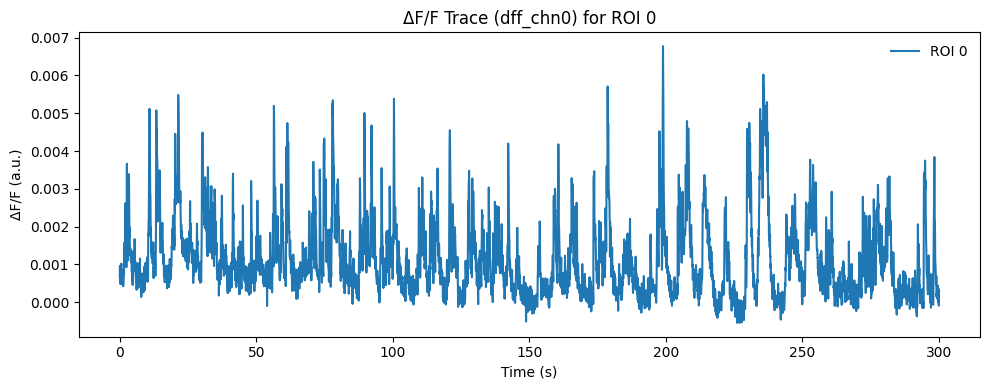

In [5]:
import numpy as np
import matplotlib.pyplot as plt

dff_chn0 = roi_response_series['dff_chn0']
dff_data = dff_chn0.data[:, 0]  # ROI 0
dff_times = np.arange(len(dff_data)) / dff_chn0.rate

plt.figure(figsize=(10, 4))
plt.plot(dff_times, dff_data, label='ROI 0')
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F (a.u.)')
plt.title('ΔF/F Trace (dff_chn0) for ROI 0')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

## 6. Visualize Spatial Footprint (Mask) of ROI 0

Each ROI has an associated spatial mask showing its extent in the imaging field. Here we extract and plot ROI 0's mask.

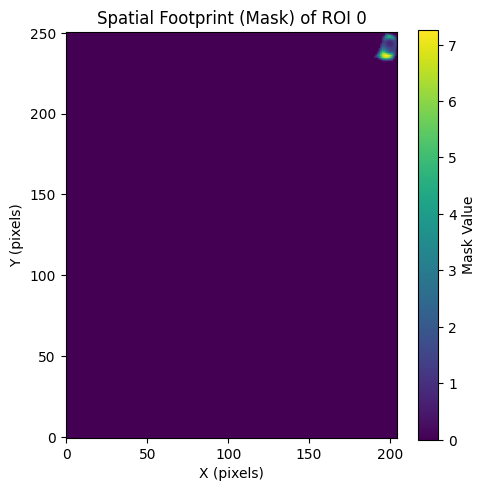

In [6]:
img_seg = processing.data_interfaces['ImageSegmentation']
plane_seg = img_seg.plane_segmentations['PlaneSegmentation_1']

# Get ROI 0 pixel mask: a list of (x, y, weight)
rois_df = plane_seg.to_dataframe()
pixel_mask = rois_df.iloc[0]['pixel_mask']

# Infer mask shape
x_coords = [int(p[0]) for p in pixel_mask]
y_coords = [int(p[1]) for p in pixel_mask]
mask_shape = (max(y_coords) + 1, max(x_coords) + 1)
mask_img = np.zeros(mask_shape, dtype=float)
for px, py, val in pixel_mask:
    mask_img[int(py), int(px)] = val

plt.figure(figsize=(5, 5))
plt.imshow(mask_img, cmap='viridis', origin='lower')
plt.colorbar(label='Mask Value')
plt.title('Spatial Footprint (Mask) of ROI 0')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.tight_layout()
plt.show()

## 7. Visualize Raw Fluorescence for ROI 0

For comparison, let's look at the raw, unnormalized fluorescence trace for ROI 0 (fluorescence_chn0).

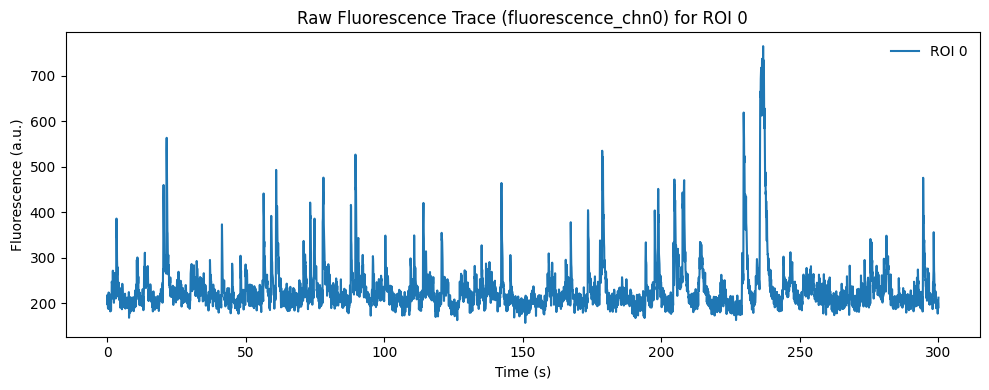

In [7]:
fluorescence_chn0 = roi_response_series['fluorescence_chn0']
raw_fluor = fluorescence_chn0.data[:, 0]
raw_times = np.arange(len(raw_fluor)) / fluorescence_chn0.rate

plt.figure(figsize=(10, 4))
plt.plot(raw_times, raw_fluor, label='ROI 0')
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (a.u.)')
plt.title('Raw Fluorescence Trace (fluorescence_chn0) for ROI 0')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

## 8. Are There Behavioral or Stimulus TimeSeries?

For this NWB file, **no behavioral or stimulus-related TimeSeries are present outside the ophys processing module**. Data here focuses exclusively on two-photon calcium imaging—no explicit behavioral or external event series are available.

## 9. Summary and Next Steps

You have now:
- Navigated a Dandiset and listed its NWB files.
- Streamed and inspected a session's calcium imaging data.
- Explored available ROI time series and segmentation masks.
- Generated basic visualizations for fluorescence and ROI footprints.

**Next steps** could include:
- Comparing activity across multiple ROIs or files.
- Computing population statistics or event-triggered averages.
- Integrating with other (potentially external) behavioral data.

For further exploration, refer to the [Dandiset landing page](https://dandiarchive.org/dandiset/001349/0.250520.1729) and the NWB documentation.

---
*Please review code, analyses, and results with care. Notebook auto-generated with AI guidance; always verify key findings before publication or downstream use!*

## Close NWB file
It's best practice to close file handles when finished.

In [8]:
io.close()
h5_file.close()
remote_file.close()